# What is Faber's trading strategy?

One buys when the monthly price of an asset exceeds its 10-month simple moving average and sells when the same price of that asset drops below its 10-month simple moving average.

# Reasons for this strategy in particular

Faber claims that a market timing strategy outperforms the market average, as shown by its consistently better performance than a simple buy-and-hold strategy.

In [1]:
%load_ext zipline

In [ ]:
# %load faber.py
from numpy import mean
from collections import defaultdict
from zipline.api import order, record, symbol, date_rules, time_rules, schedule_function

def initialize(context):
    """
    Stores the names of the stocks we'll be looking at.
    
    Input: a persistent namespace where we store an SID/list of SIDs
    
    Output: n/a
    """

    # context.symbol = [symbol('GOOG'),
    #                   symbol('MSFT'),
    #                   symbol('JPM'),
    #                   symbol('AMZN')]

    # set initial cash to 1 mil
    context.portfolio.starting_cash = 1000000

    context.symbol = [symbol('XLB'),
                      symbol('XLE'),
                      symbol('XLF'), 
                      symbol('XLK'), 
                      symbol('XLP'), 
                      symbol('XLY')]

    # skip the first 300 days of the timeframe so that we have enough data to calculate our 10 month SMA
    context.skip = 0

    # keep track of number of shares bought
    context.shares = defaultdict(int)
    context.moving_avg = defaultdict(int)
    context.monthly_price = defaultdict(list)

    # skip the first 10 months so that we have enough data to establish our moving average
    schedule_function(trade, date_rules.month_end(), time_rules.market_close())

def handle_data(context, data):
    """
    Calls the trading strategy function at the end of every month.
    
    Input: persistent namespace with SID(s) 'context', event-frame that handles look-ups of historical/current pricing data
    
    Output: some kind of action (buy/sell/nothing)
    """
    pass

def trade(context, data):
    """
    Herein lies Faber's trading strategy.
    
    Input: persistent namespace with SID(s) 'context', event-frame that handles look-ups of historical/current pricing data
    
    Output: some kind of action (buy/sell/nothing) on the last trading day of each month
    """

    context.skip += 1

    if context.skip < 10:
        for asset in context.symbol:
            price = data.current(asset, 'price')
            context.monthly_price[asset].append(price)

    else:
        for asset in context.symbol:
            price = data.current(asset, 'price')

            # Get closing price on last trading day of month
            context.monthly_price[asset].append(price)
            context.monthly_price[asset] = context.monthly_price[asset][1:11]

            # calculate the 10-month moving average of each asset
            context.moving_avg[asset] = mean(context.monthly_price[asset])

        
        ### Faber's trading strategy ###
        
        # if the current price exceeds moving average, long
        for asset in context.symbol:
            # the most current monthly price will be the one added most recently (so it'll be the element on the end of the list)
            # also check that 
            if context.monthly_price[asset][-1] > context.moving_avg[asset] and context.portfolio.cash > -1000000:
                order(asset, 500)
                context.shares[asset] += 500

            # else if the current price is below moving average, short
            elif context.monthly_price[asset][-1] < context.moving_avg[asset] and context.shares[asset] > 0:
                order(asset, -context.shares[asset])
                context.shares[asset] = 0

            # save/record the data for future plotting
            record(asset = context.monthly_price[asset][-1], sma = context.moving_avg[asset])

            # # also record the S&P 500 monthly price
            # record(SPY = data.current(symbol('SPY'), 'close'))
     
def analyze(context = None, results = None):
    """
    Plots the results of the strategy against a buy-and-hold strategy.
    
    Input: n/a?
    
    Output: a plot of two superimposed curves, one being Faber's strategy and the other being a buy-and-hold strategy.
    """
    import matplotlib.pyplot as plt

    fig = plt.figure()
    ax1 = fig.add_subplot(211)

    # plot both the portfolio based on faber's strategy and a buy-and-hold strategy
    results.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel('Portfolio value (USD)')

    # ax2 = fig.add_subplot(212)
    # ax2.set_ylabel('Price (USD)')
    # 
    # If data has been record()ed, then plot it.
    # Otherwise, log the fact that no data has been recorded.
    # if ('AAPL' in results and 'sma' in results):
        # results['AAPL'].plot(ax=ax2)
        # results['sma'].plot(ax=ax2)

        # trans = results.ix[[t != [] for t in results.transactions]]
        # buys = trans.ix[[t[0]['amount'] > 0 for t in
        #                  trans.transactions]]
        # sells = trans.ix[
        #     [t[0]['amount'] < 0 for t in trans.transactions]]
        # ax2.plot(buys.index, results.sma.ix[buys.index],
        #          '^', markersize=10, color='m')
        # ax2.plot(sells.index, results.sma.ix[sells.index],
        #          'v', markersize=10, color='k')
        # plt.legend(loc=0)
    # else:
    #     msg = 'Data not captured using record().'
    #     ax2.annotate(msg, xy=(0.1, 0.5))
    #     log.info(msg)

    plt.show()     

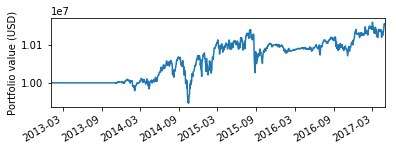

,algo_volatility,algorithm_period_return,alpha,asset,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,...,short_value,shorts_count,sma,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2013-01-02 21:00:00+00:00,NaN,0.000000,NaN,NaN,0.025630,NaN,NaN,0.000000,1.000000e+07,0.000,...,0,0,NaN,NaN,1.000000e+07,0.000,0.000,1,[],0.0186
2013-01-03 21:00:00+00:00,0.000000,0.000000,0.000000,NaN,0.023313,0.313060,0.000000,0.000000,1.000000e+07,0.000,...,0,0,NaN,NaN,1.000000e+07,0.000,0.000,2,[],0.0192
2013-01-04 21:00:00+00:00,0.000000,0.000000,0.000000,NaN,0.027807,0.231240,0.000000,0.000000,1.000000e+07,0.000,...,0,0,NaN,NaN,1.000000e+07,0.000,0.000,3,[],0.0193
2013-01-07 21:00:00+00:00,0.000000,0.000000,0.000000,NaN,0.024998,0.211424,0.000000,0.000000,1.000000e+07,0.000,...,0,0,NaN,NaN,1.000000e+07,0.000,0.000,4,[],0.0192
2013-01-08 21:00:00+00:00,0.000000,0.000000,0.000000,NaN,0.022049,0.194244,0.000000,0.000000,1.000000e+07,0.000,...,0,0,NaN,NaN,1.000000e+07,0.000,0.000,5,[],0.0189
2013-01-09 21:00:00+00:00,0.000000,0.000000,0.000000,NaN,0.024647,0.174168,0.000000,0.000000,1.000000e+07,0.000,...,0,0,NaN,NaN,1.000000e+07,0.000,0.000,6,[],0.0188
2013-01-10 21:00:00+00:00,0.000000,0.000000,0.000000,NaN,0.032793,0.160648,0.000000,0.000000,1.000000e+07,0.000,...,0,0,NaN,NaN,1.000000e+07,0.000,0.000,7,[],0.0191
2013-01-11 21:00:00+00:00,0.000000,0.000000,0.000000,NaN,0.032722,0.151083,0.000000,0.000000,1.000000e+07,0.000,...,0,0,NaN,NaN,1.000000e+07,0.000,0.000,8,[],0.0189
2013-01-14 21:00:00+00:00,0.000000,0.000000,0.000000,NaN,0.032020,0.143545,0.000000,0.000000,1.000000e+07,0.000,...,0,0,NaN,NaN,1.000000e+07,0.000,0.000,9,[],0.0189
2013-01-15 21:00:00+00:00,0.000000,0.000000,0.000000,NaN,0.032722,0.136097,0.000000,0.000000,1.000000e+07,0.000,...,0,0,NaN,NaN,1.000000e+07,0.000,0.000,10,[],0.0186


In [4]:
%zipline --start 2013-1-1 --end 2017-5-1 -b faber-bundle